## Convolutional Neural Networks for classifying UXO

In [1]:
import numpy as np
import os
import h5py
import pandas as pd
from scipy import stats
import torch
import urllib

import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from mpl_toolkits import mplot3d

import verde as vd

from string import ascii_lowercase

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 14
np.random.seed(2020)
torch.manual_seed(13)

In [3]:
data_directory = "./data"

if not os.path.exists(data_directory):
    os.mkdir(data_directory)

In [4]:
save_figures = False  # overwrite the saved figures? 

In [5]:
ntx = 5
ymax = 3. 
y_spacing = 0.2
dy = y_spacing / ntx
nloc = int(ymax/dy)
ncycles = int(nloc/ntx)

class_dict = {
    0: "not TOI",
    1: "ISO Small",
    2: "ISO Medium", 
    3: "ISO Large",
    4: "clutter",
}
n_class = len(class_dict.keys())

## download data if not already stored locally

We don't use the clean data for training, test, or validation, so I have commented them out, but if you would like to access them, you can uncomment those lines.

In [6]:
base_url = "https://storage.googleapis.com/simpeg/uxo-heagy-et-al/"
data_files = [
#     "data_clean_train.npy",
#     "data_clean_test.npy",
#     "data_clean_valid.npy",
    "data_train.npy",
    "data_test.npy",
    "data_valid.npy",
    "pos.npy", 
    "times.npy",
    "sensor_table.npy",
    "labels_train.npy",
    "labels_test.npy",
    "labels_valid.npy",
    "params_train.h5",
    "params_test.h5",
    "params_valid.h5",
    "data_profile.npz",
    "params_profile.h5",
    "synthetic_test_plot.npz",
    "synthetic_subset.h5"
]

for f in data_files: 
    file = os.path.sep.join([data_directory, f])
    if not os.path.exists(file):
        url = base_url + f
        urllib.request.urlretrieve(url, file)

In [7]:
data_train = np.load(os.path.sep.join([data_directory, "data_train.npy"]))
data_test = np.load(os.path.sep.join([data_directory, "data_test.npy"]))
data_valid = np.load(os.path.sep.join([data_directory, "data_valid.npy"]))
pos = np.load(os.path.sep.join([data_directory, "pos.npy"]))
times = np.load(os.path.sep.join([data_directory, "times.npy"]))
sensor_table = np.load(os.path.sep.join([data_directory, "sensor_table.npy"]))
labels_train = np.load(os.path.sep.join([data_directory, "labels_train.npy"]))
labels_test = np.load(os.path.sep.join([data_directory, "labels_test.npy"]))
labels_valid = np.load(os.path.sep.join([data_directory, "labels_valid.npy"]))


# data_clean_train = np.load(os.path.sep.join([data_directory, "data_clean_train.npy"]))
# data_clean_test = np.load(os.path.sep.join([data_directory, "data_clean_test.npy"]))
# data_clean_valid = np.load(os.path.sep.join([data_directory, "data_clean_valid.npy"]))


## data normalizations

- scale by time
- normalize by max amplitude so each set of 165 time-series is bounded between -1, 1

In [8]:
time_scaling = (times)
time_scaling

array([0.154, 0.171, 0.19 , 0.211, 0.235, 0.262, 0.292, 0.325, 0.361,
       0.401, 0.446, 0.496, 0.551, 0.613, 0.681, 0.758, 0.842, 0.936,
       1.04 , 1.156, 1.286, 1.429, 1.588, 1.764, 1.961, 2.178, 2.42 ])

In [9]:
tmp = data_test * time_scaling 

In [10]:
scaled_data_train = data_train * time_scaling
scaled_data_test = data_test*time_scaling
scaled_data_valid = data_valid*time_scaling

In [11]:
def normalize_data(d, eps=1e-6): 
    dd = d.reshape(d.shape[0], np.prod(d.shape[1:]), order="F")
    normalize_by = np.max(np.abs(dd), 1) + eps # make sure we don't divide by zero
    return (dd.T/normalize_by).T.reshape(d.shape, order="F")

In [12]:
normalized_data_train = normalize_data(scaled_data_train)
normalized_data_test = normalize_data(scaled_data_test)
normalized_data_valid = normalize_data(scaled_data_valid)

### plot a histogram of data before and after normalizations

These are expensive plots, so I have commented them out, uncomment to view

In [13]:
# eps = 1e-6

# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax = ax.flatten()

# for a, data, labels, title in zip(
#     ax, 
#     [data_train, data_test, data_valid], 
#     [labels_train, labels_test, labels_valid],
#     ["train", "test", "valid"]
# ):
#     data = np.stack(data, 0)
#     for j in range(n_class):
#         inds = labels == j
#         a.hist(np.log10(np.abs(data[inds, :, :, :]) + eps).flatten(), 100, color=f"C{j}", alpha=0.6)
#         a.set_title(title)
#         a.set_ylim([0, data.shape[0]*1.1e3])

# ax[2].legend(list(class_dict.values()))
# plt.tight_layout()

In [14]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax = ax.flatten()

# for a, data, labels, title in zip(
#     ax, 
#     [scaled_data_train, scaled_data_test, scaled_data_valid], 
#     [labels_train, labels_test, labels_valid],
#     ["train", "test", "valid"]
# ):
#     data = np.stack(data, 0)
#     for j in range(n_class):
#         inds = labels == j
#         a.hist(np.log10(np.abs(data[inds, :, :, :])+eps).flatten(), 100, color=f"C{j}", alpha=0.6)
#         a.set_title(title)
#         a.set_ylim([0, data.shape[0]*1.1e3])

# ax[2].legend(list(class_dict.values()))
# plt.tight_layout()

In [15]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# ax = ax.flatten()

# for a, data, labels, title in zip(
#     ax, 
#     [normalized_data_train, normalized_data_test, normalized_data_valid], 
#     [labels_train, labels_test, labels_valid],
#     ["train", "test", "valid"]
# ):
# #     data = np.stack(data, 0)
#     for j in range(n_class):
#         inds = labels == j
#         a.hist(np.log10(np.abs(data[inds, :, :, :])+eps).flatten(), 100, color=f"C{j}", alpha=0.6)
#         a.set_title(title)
#         a.set_ylim([0, data.shape[0]*1.1e3])

# ax[2].legend(list(class_dict.values()))
# plt.tight_layout()

<>:37: DeprecationWarning: invalid escape sequence \p
<>:37: DeprecationWarning: invalid escape sequence \p
<>:37: DeprecationWarning: invalid escape sequence \p
<ipython-input-16-fe626d76d4f0>:37: DeprecationWarning: invalid escape sequence \p
  a.set_ylabel("$\partial {b}/\partial t$ (mV)")


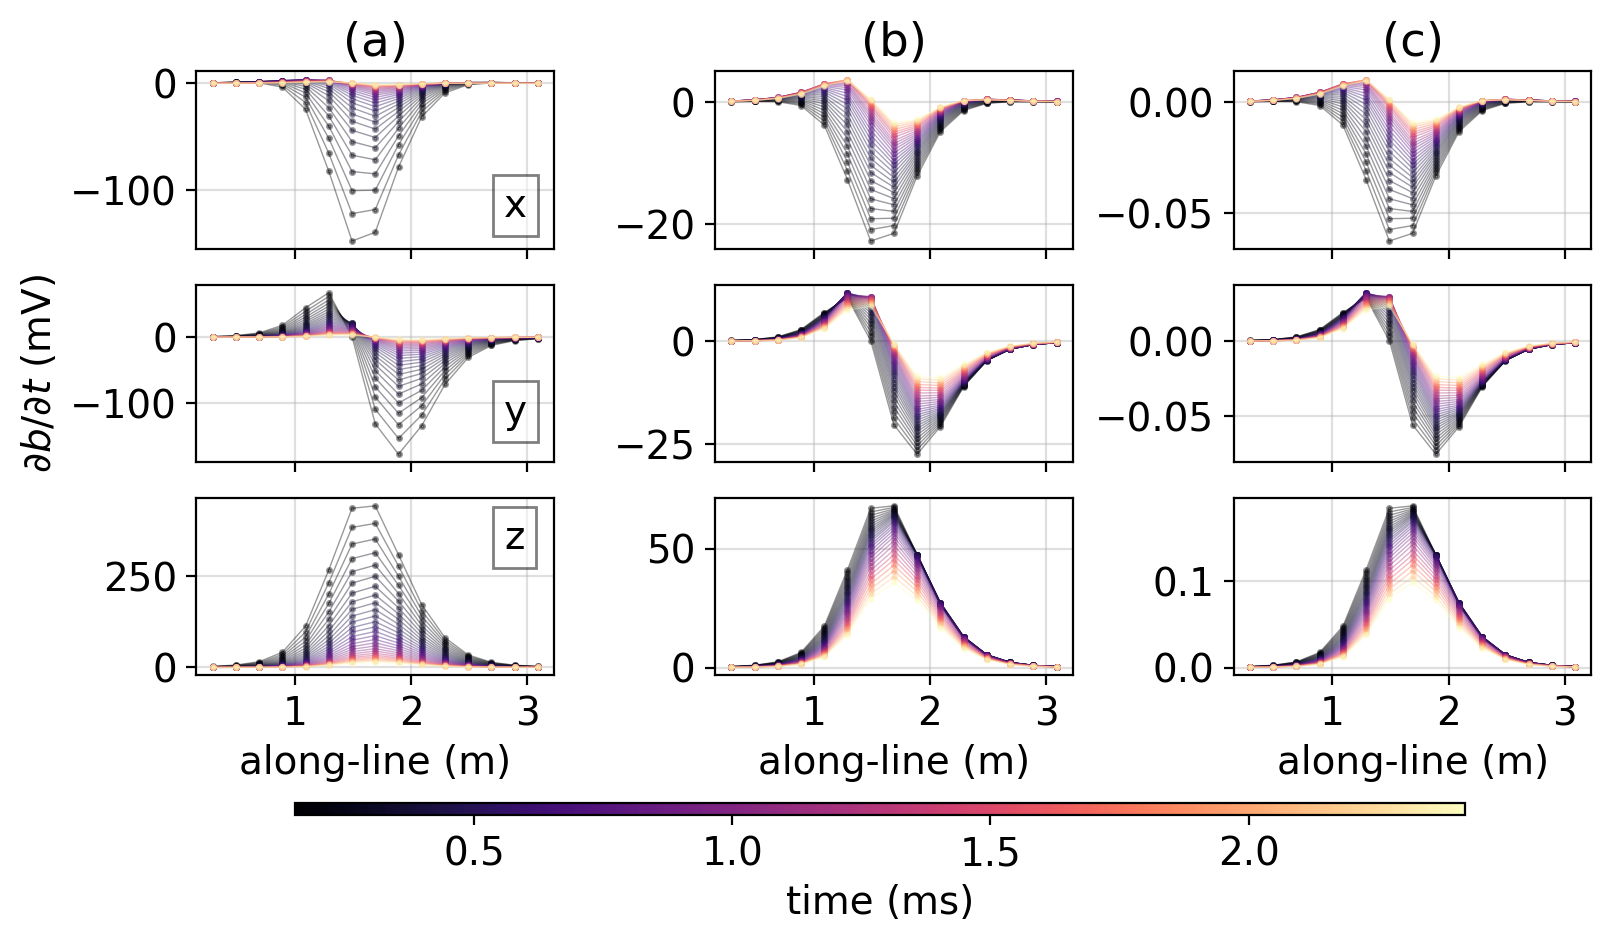

In [16]:
dind = 28

fig, ax = plt.subplots(3, 3, figsize=(9, 4), dpi=200, sharex=True)
fig.subplots_adjust(wspace=0.45, hspace=0.2)

plot_tx = 1
plot_rx = 7
tx_inds = (sensor_table[:, 0] == plot_tx)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i, axs, d in zip(
    [0, 1, 2],
    [ax[:, 0], ax[:, 1], ax[:, 2]],
    [data_train[dind, :, :, :], scaled_data_train[dind, :, :, :], normalized_data_train[dind, :, :, :]]
):

    ii = tx_inds & (sensor_table[:, 3] == plot_rx)

    for a, comp in zip(axs, [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        for t in range(len(times)):
            a.plot(
                pos[mnumind, :, 1], d[mnumind, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

        a.grid(which="both", alpha=0.4)

        if i == 0: 
            if comp == 0:
                a.text(2.8, -125, "x", bbox=dict(facecolor='w', alpha=0.5))
            if comp == 1:
                a.set_ylabel("$\partial {b}/\partial t$ (mV)")
                a.text(2.8, -130, "y", bbox=dict(facecolor='w', alpha=0.5))
            elif comp == 2:
                a.text(2.8, 325, "z", bbox=dict(facecolor='w', alpha=0.5))
        
        if comp == 0:
            a.set_title(f"({ascii_lowercase[i]})")
        if comp == 2:
            a.set_xlabel("along-line (m)")
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, -0.05, 0.65, 0.015])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

if save_figures: 
    fig.savefig("figures/data_normalizations", bbox_inches="tight")


We can think of the data "images" going into the CNN as nT by nx pixels

Text(0.5, 0.92, 'Transmitter 1, Target 28: ISO Medium')

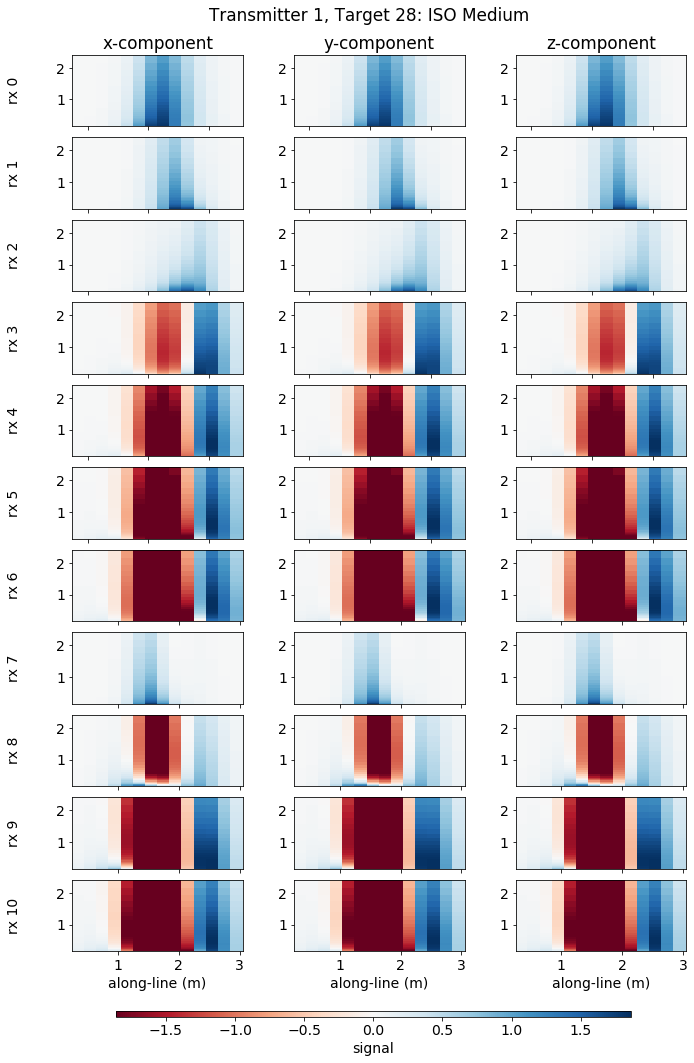

In [17]:
nrx = 11
fig, ax = plt.subplots(nrx, 3, figsize=(11, 1.5*nrx))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

plot_tx = 0
tx_inds = (sensor_table[:, 0] == plot_tx)

d = scaled_data_train[dind]

for rx in range(nrx):
    ii = tx_inds & (sensor_table[:, 3] == rx)
    plotme = d[mnumind, :, :].T
    for a, comp in zip(ax[rx, :], [0, 1, 2]):
        mnumind = np.where( ii & (sensor_table[:, 2] == comp))[0][0]
        out = a.pcolormesh(
            pos[mnumind, :, 1], times, 
            plotme, cmap="RdBu", vmin=-(np.abs(plotme.max())).max(), vmax=(np.abs(plotme.max())).max()
        )

#         a.grid(which="both", alpha=0.4)
#         a.set_aspect(1)
        if rx < nrx-1:
            a.set_xticklabels('')
        else:
            a.set_xlabel("along-line (m)")
        
        if rx == 0:
            if comp == 0:
                a.set_title("x-component")
            elif comp == 1:
                a.set_title("y-component")
            elif comp == 2:
                a.set_title("z-component")
        
        if comp == 0:
            a.set_ylabel(f"rx {rx}")
            a.yaxis.set_label_coords(-0.3, 0.5)

cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(out, cbar_ax, orientation="horizontal")
cb.set_label('signal')

fig.suptitle(f"Transmitter {plot_tx+1}, Target {dind}: {class_dict[labels_train[dind]]}", y=0.92)


# build a ConvNet classifier 

In [18]:
# import torch
from torch import nn
from torch.nn import functional

In [19]:
use_scaled = False
use_normalized = True

if use_scaled is True: 
    X_train = torch.from_numpy(np.float32(scaled_data_train))
    X_test = torch.from_numpy(np.float32(scaled_data_test))
    X_valid = torch.from_numpy(np.float32(scaled_data_valid))

elif use_normalized is True: 
    X_train = torch.from_numpy(np.float32(normalized_data_train))
    X_test = torch.from_numpy(np.float32(normalized_data_test))
    X_valid = torch.from_numpy(np.float32(normalized_data_valid))

else: 
    X_train = torch.from_numpy(np.float32(data_train))
    X_test = torch.from_numpy(np.float32(data_test))
    X_valid = torch.from_numpy(np.float32(data_valid))

C_train = torch.from_numpy(np.float32(labels_train)).long()
C_test = torch.from_numpy(np.float32(labels_test)).long()
C_valid = torch.from_numpy(np.float32(labels_valid)).long()

In [20]:
class ConvNet(nn.Module):
    
    def __init__(self, network_geometry):
        super().__init__()
        self.network_geometry=network_geometry
        self.nt = len(network_geometry)
        self.batch_norm = nn.BatchNorm2d(network_geometry[0])
    
    def forward(self, X, K, batch_norm, bias=None): 
        X = self.batch_norm(X)
        if bias is None:
            bias = [None]*len(K)
        for i, Ki, bn, b in zip(range(self.nt), K, batch_norm, bias):
            z = functional.conv2d(X, Ki, stride=1, padding=1, bias=b)
            z = bn(z)
            z = functional.relu(z)
            z = functional.max_pool2d(z, 3, stride=1, padding=1)
            X = z
        return X

In [21]:
in_channels = 165
layer_geometries = [in_channels, 33, 11] #11, 11, 11]
nlayers = len(layer_geometries)
initial_scaling = 1e-3

width = nloc//ntx
ntimes = len(times)

# initialize K's and batch normalizations
K = []
batch_norm = []
bias = None #[]
for i in range(nlayers-1):
    n_in = layer_geometries[i]
    n_out = layer_geometries[i+1]
    Ki = nn.Parameter(torch.Tensor(n_out, n_in, 3, 3))
    Ki.data = torch.randn(n_out, n_in, 3, 3)  * initial_scaling
    K.append(Ki)
    
#     bi = nn.Parameter(torch.Tensor(n_out))
#     bi.data = torch.randn(n_out) * initial_scaling
#     bias.append(bi)
    
    batch_norm.append(nn.BatchNorm2d(n_out))

# initialize classifier W
coarsening = (len(layer_geometries)  - 1)*0
W = nn.Parameter(torch.Tensor(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class))
W.data = torch.randn(layer_geometries[-1]*(width-coarsening)*(ntimes-coarsening), n_class)*initial_scaling

b = nn.Parameter(torch.randn(n_class)*initial_scaling, requires_grad=True)

In [22]:
net = ConvNet(layer_geometries)

In [23]:
# run the network

with torch.no_grad():
    out = net(X_train, K, batch_norm, bias)

In [24]:
loss_func = nn.CrossEntropyLoss()

def classify(X, W, b): 
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)
    S = functional.softmax(S, dim=1)
    _, C = torch.max(S, axis=1)
    return C, S

def misfit(X, W, b, C):
    n = W.shape
    X = X.view(-1, n[0])
    S = torch.matmul(X, W) + b.unsqueeze(0)

    probs = functional.softmax(S, dim=1)
    return loss_func(S, C), probs

In [25]:
n_parout = (
    np.sum(np.array([np.prod(Ki.shape) for Ki in K])) + np.prod(W.shape)  #+ np.sum(np.array([np.prod(bi.shape) for bi in bias]))
)

print('Total number of parameters', n_parout)
print('Total number of data', labels_train.shape[0])

Total number of parameters 74547
Total number of data 8192


In [26]:
def accuracy(S, labels):
    _, predicted = torch.max(S, dim=1)
    total = np.prod(labels.size())
    correct = (predicted == labels).sum().item()
    return correct/total

In [27]:
loss, probs = misfit(out, W, b, C_train)
print('Initial loss = ', loss.detach().numpy())    
print(f'Check:log({n_class}) = ', np.log(n_class))

print(f"\nInitial accuracy: {accuracy(probs, C_train)}")
print(f"Check random    : {1/n_class}")

Initial loss =  1.6025999
Check:log(5) =  1.6094379124341003

Initial accuracy: 0.2166748046875
Check random    : 0.2


In [28]:
import torch.optim as optim
optimizer = optim.SGD(
    [{'params': W}, {'params':b}, {'params': K}], #, {'params': bias}], 
    lr = 0.25, momentum=0
)
# lr_cooling = 0.5

In [29]:
running_loss_train = []
running_loss_test = []
running_accuracy_train = []
running_accuracy_test = []

In [30]:
batch_size = 32

for epoch in range(10):  # loop over the dataset multiple times

    # zero the parameter gradients
    g = 0.0
    loss = 0.0
    ind = 0
    
    while ind < X_train.shape[0]:    
        optimizer.zero_grad()
        # get the inputs
        inputs = X_train[ind:ind+batch_size, :, :, :]
        labels = C_train[ind:ind+batch_size]

        # forward 
        x = net(inputs, K, batch_norm, bias)
        lossi, _ = misfit(x, W, b, labels)
        if i==0:
            loss = lossi
        else:
            loss += lossi
        lossi.backward()
        optimizer.step()
        ind += batch_size
    
#     if np.mod(epoch, 4) == 0 and epoch > 0: 
#         print("cooling lr")
#         for opt_param in optim.param_groups:
#             opt_paral["lr"] *= lr_cooling
        
    with torch.no_grad():
        xtest = net(X_test, K, batch_norm, bias)
        loss_test, probs_test = misfit(xtest, W, b, C_test)

        xtrain = net(X_train, K, batch_norm, bias)
        loss_train, probs_train = misfit(xtrain, W, b, C_train)

        accuracy_train = accuracy(probs_train, C_train)
        accuracy_test = accuracy(probs_test, C_test)

        g = torch.norm(W.grad) + sum([torch.norm(Ki.grad) for Ki in K]) + torch.norm(b.grad)

        running_loss_train.append(loss_train)
        running_loss_test.append(loss_test)
        running_accuracy_train.append(accuracy_train)
        running_accuracy_test.append(accuracy_test)
     
        print(f'{epoch:3d}  {loss:2.3e}  {loss_test:2.3e} {g:2.3e} {accuracy_train:0.3f}  {accuracy_test:0.3f}')

print('Finished Training')

  0  4.267e+03  5.736e+00 1.044e+01 0.433  0.432
  1  1.129e+03  1.100e+00 9.548e-01 0.484  0.463
  2  2.402e+02  7.083e-01 1.618e+00 0.707  0.729
  3  1.609e+02  4.581e-01 1.798e+00 0.819  0.821
  4  1.077e+02  3.140e-01 1.752e+00 0.885  0.879
  5  5.953e+01  1.443e-01 1.224e+00 0.956  0.958
  6  3.888e+01  1.043e-01 1.474e+00 0.975  0.970
  7  2.478e+01  8.008e-02 7.644e-01 0.981  0.979
  8  3.752e+01  1.441e-01 2.969e+00 0.951  0.949
  9  2.018e+01  5.956e-02 7.462e-01 0.987  0.976
Finished Training


In [31]:
# training set
x_train_net = net(X_train, K, batch_norm, bias)
_, probs_train = misfit(x_train_net, W, b, C_train)
_, pred_train = torch.max(probs_train, dim=1)

# test set
x_test_net = net(X_test, K, batch_norm, bias)
_, probs_test = misfit(x_test_net, W, b, C_test)
_, pred_test = torch.max(probs_test, dim=1)

# validation set
x_valid_net = net(X_valid, K, batch_norm, bias)
_, probs_valid = misfit(x_valid_net, W, b, C_valid)
_, pred_valid = torch.max(probs_valid, dim=1)

In [32]:
print(f"training accuracy: {accuracy(probs_train, C_train):1.4f}")
print(f"test accuracy    : {accuracy(probs_test, C_test):1.4f}")
print(f"valid accuracy   : {accuracy(probs_valid, C_valid):1.4f}")

training accuracy: 0.9871
test accuracy    : 0.9756
valid accuracy   : 0.9814


In [33]:
# see where it struggled

def get_mislabeled(S, labels):
    _, predicted = torch.max(S, dim=1)
    incorrect = (predicted != labels)
    return incorrect.numpy()

In [34]:
mislabeled_train = get_mislabeled(probs_train, C_train)
mislabeled_test = get_mislabeled(probs_test, C_test)
mislabeled_valid = get_mislabeled(probs_valid, C_valid)

_, pred_labels_train = torch.max(probs_train, dim=1)
_, pred_labels_test = torch.max(probs_test, dim=1)
_, pred_labels_valid = torch.max(probs_valid, dim=1)

print(f"Mislabeled. train: {mislabeled_train.sum()}, test: {mislabeled_test.sum()}, valid: {mislabeled_valid.sum()}")

Mislabeled. train: 106, test: 25, valid: 19


In [35]:
def confusion_matrix(true_labels, predicted_labels):
    n = len(np.unique(true_labels))
    M = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            M[i, j] = sum((true_labels == i) & (predicted_labels == j))
    return M

In [36]:
print(f"rows = True: {class_dict.values()}")
print(f"cols = Pred: {class_dict.values()}")

rows = True: dict_values(['not TOI', 'ISO Small', 'ISO Medium', 'ISO Large', 'clutter'])
cols = Pred: dict_values(['not TOI', 'ISO Small', 'ISO Medium', 'ISO Large', 'clutter'])


In [37]:
confusion_matrix(C_train, pred_labels_train)

array([[1625,    0,    0,    0,    0],
       [   0, 1569,    1,    1,   17],
       [   0,    1, 1548,   34,   27],
       [   0,    0,    7, 1689,    5],
       [   0,   11,    0,    2, 1655]])

In [38]:
confusion_matrix(C_test, pred_labels_test)

array([[192,   0,   0,   0,   0],
       [  0, 193,   1,   0,   7],
       [  0,   0, 175,   7,   3],
       [  0,   0,   3, 210,   1],
       [  0,   2,   0,   1, 229]])

In [39]:
confusion_matrix(C_valid, pred_labels_valid)

array([[204,   0,   0,   0,   0],
       [  0, 192,   1,   0,   3],
       [  0,   1, 201,   5,   3],
       [  0,   0,   4, 223,   1],
       [  0,   0,   0,   1, 185]])

In [40]:
inds, vals = torch.max(probs_valid[mislabeled_valid, :], dim=0)

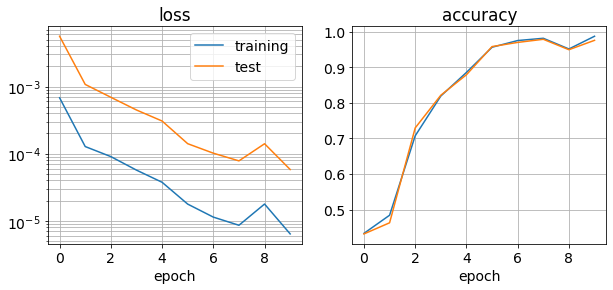

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].semilogy(1/len(data_train) * np.array(running_loss_train), label="training")
ax[0].semilogy(1/len(data_test) * np.array(running_loss_test), label="test")
ax[0].set_title("loss")
ax[0].legend()

ax[1].plot(running_accuracy_train, label="training")
ax[1].plot(running_accuracy_test, label="test")
ax[1].set_title("accuracy")

for a in ax:
    a.grid(which="both")
    a.set_xlabel("epoch")

## look at features in network 

In [42]:
params_train = pd.read_hdf(os.path.sep.join([data_directory, "params_train.h5"]), "df")

//miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [43]:
ind = 6

print(probs_train[ind, :])
print(f"class: {class_dict[labels_train[ind]]}")

params_train.iloc[ind]

tensor([1., 0., 0., 0., 0.], grad_fn=<SliceBackward>)
class: not TOI


label              0.000000
depth              0.000000
x                  1.691520
y                  0.254051
z                 -0.000000
yaw                5.486218
pitch              2.344794
roll               2.618872
noise_amplitude    0.000203
polarizations      0.000000
clutter_type       0.000000
Name: 6, dtype: float64

In [44]:
X_train.shape, len(K)

(torch.Size([8192, 165, 15, 27]), 2)

In [45]:
Z0 = []
Z1 = []
Z2 = []
Z3 = []
with torch.no_grad():
    X = X_train[ind:ind+1, :, :, :]
    for Ki, bn in zip(K, batch_norm):
        print(Ki.shape)
        z0 = functional.conv2d(X, Ki, stride=1, padding=1)
        z1 = bn(z0)
        z2 = functional.relu(z1)
        z3 = functional.max_pool2d(z2, 3, stride=1, padding=1)
        X = z2
        Z0.append(z0)
        Z1.append(z1)
        Z2.append(z2)
        Z3.append(z3)

torch.Size([33, 165, 3, 3])
torch.Size([11, 33, 3, 3])


In [46]:
K[1].shape

torch.Size([11, 33, 3, 3])

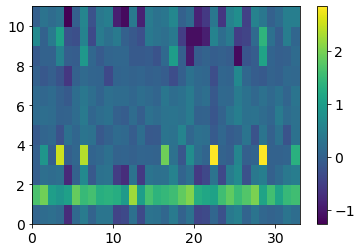

In [47]:
plt.colorbar(plt.pcolormesh(K[1][:, :, 2, 1].data.numpy()))

tensor(-4.4425) tensor(4.4425)


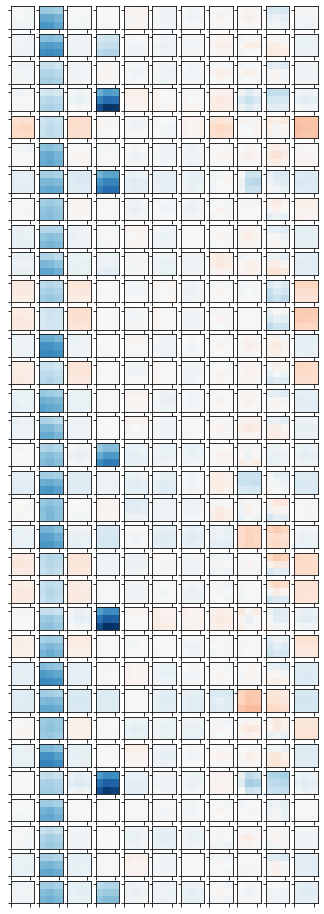

In [48]:
fig, ax = plt.subplots(33, 11, figsize = (11*0.5, 33*0.5))

plotme = K[1].detach()
vmax=np.abs(plotme.flatten()).max()
vmin=-vmax
print(vmin, vmax)

for i in range(33):
    for j in range(11):
        a = ax[i, j]
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.pcolormesh(plotme[j, i, :, :], vmin=vmin, vmax=vmax, cmap="RdBu")
# K[1].shape

In [49]:
w_plot = []
with torch.no_grad():
    for i in range(n_class):
        w_plot.append(W[:, i].view(Z2[1].shape).detach())

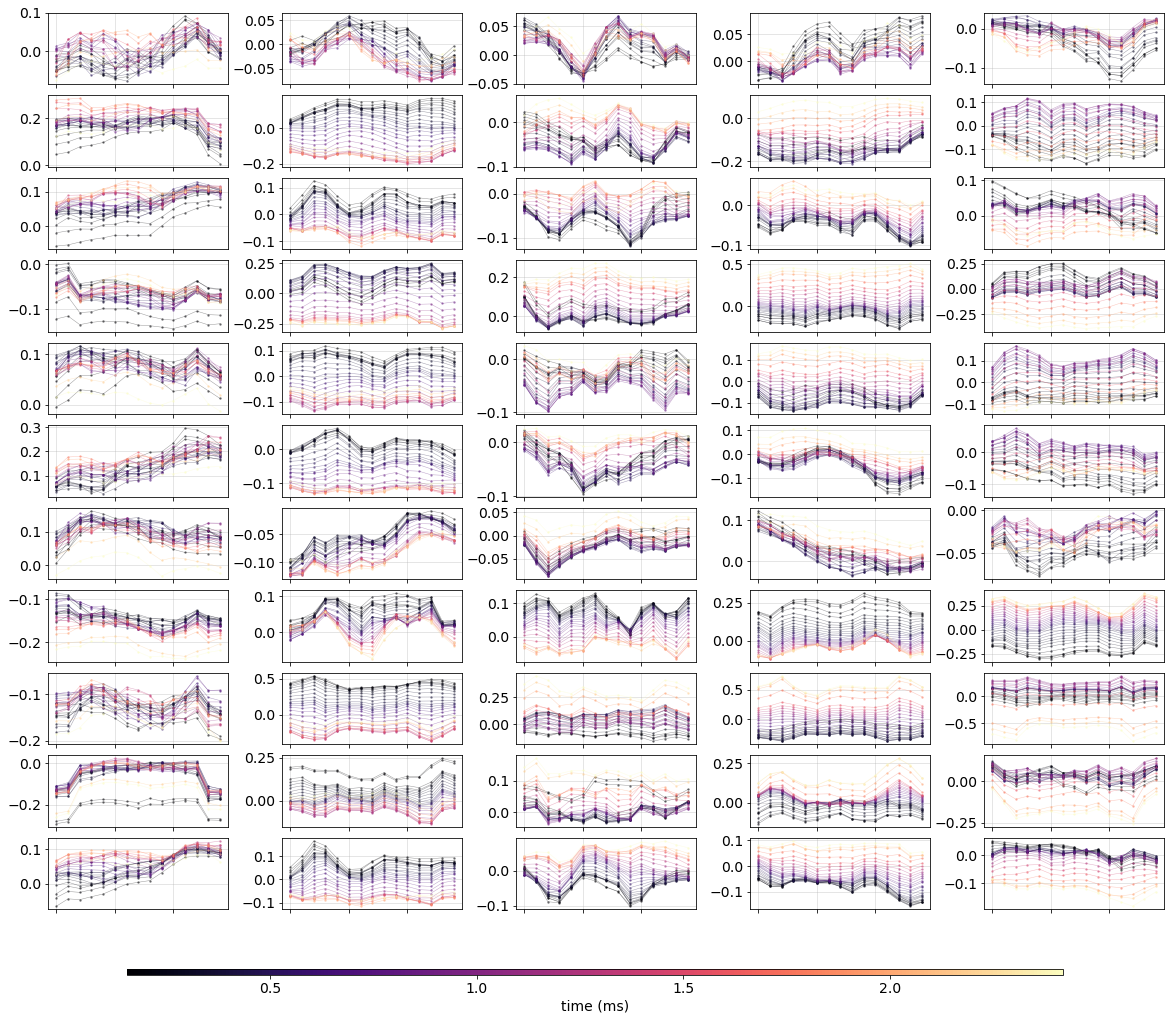

In [50]:
nfeatures = 11
fig, ax = plt.subplots(11, len(w_plot), figsize=(4*len(w_plot), 1.5*11))
fig.subplots_adjust(wspace=0.3, hspace=0.15)

cm = plt.get_cmap('magma')
c_norm = Normalize(vmin=times.min(), vmax=times.max())
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for ii, w in enumerate(w_plot):
    for i, a in enumerate(ax[:, ii]):
        for t in range(w.shape[-1]):
            a.plot(
                w[0, i, :, t], 
                color=scalar_map.to_rgba(times[t]), marker=".", lw=0.5, alpha=0.4, ms=3
            )

            a.grid(which="both", alpha=0.4)
            if ii < nfeatures-1:
                a.set_xticklabels('')
            
# plt.tight_layout()
cbar_ax = fig.add_axes([0.18, 0.07, 0.65, 0.005])
cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
cb.set_label('time (ms)')

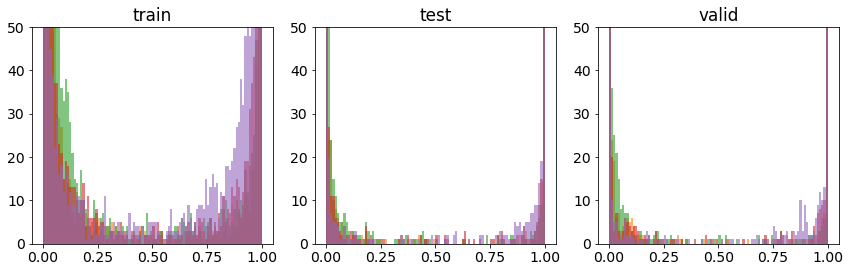

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for a, probs, title in zip(ax, [probs_train, probs_test, probs_valid], ["train", "test", "valid"]):
    a.set_title(title)
    for i in range(n_class):
        a.hist(probs[:, i].detach().numpy(), 100, color=f"C{i}", alpha=0.6)

        a.set_ylim([0, 50])
# ax[0].legend([class_dict[0], class_dict[1], class_dict[2]])
plt.tight_layout()

# classify a line of data


In [52]:
profile = np.load(os.path.sep.join([data_directory, "data_profile.npz"]))
params_profile = pd.read_hdf(os.path.sep.join([data_directory, "params_profile.h5"]))

X_profile = profile["x"]
Y_profile = profile["y"]
D_profile = profile["data"]
depths_profile = params_profile["depth"].to_numpy()

In [53]:
window_width_profile = int(ymax/y_spacing)
w_step_profile = 3
n_windows_profile = (X_profile.shape[1]-window_width_profile)//w_step_profile
print(n_windows_profile)

61


In [54]:
n = D_profile.shape
net_data_profile = np.zeros((n_windows_profile, n[0], window_width_profile, n[2]))
net_y_profile = np.zeros((n_windows_profile, n[0], window_width_profile))
net_x_profile = np.zeros((n_windows_profile, n[0], window_width_profile))

for i in range(n_windows_profile):
    inds = slice(i*w_step_profile,i*w_step_profile+window_width_profile)
    net_x_profile[i, :, :] = X_profile[:, inds]
    net_y_profile[i, :, :] = Y_profile[:, inds]
    net_data_profile[i, :, :, :] = D_profile[:, inds, :]

In [55]:
if use_scaled is True or use_normalized is True:
    print("scaling by time")
    net_data_profile_torch = net_data_profile*time_scaling
else:
    net_data_profile_torch = net_data_profile
    
if use_normalized is True:
    print("normalizing")
    net_data_profile_torch = normalize_data(net_data_profile_torch)

net_data_profile_torch = torch.from_numpy(np.float32(net_data_profile_torch))

scaling by time
normalizing


In [56]:
with torch.no_grad():
    out_field = net(net_data_profile_torch, K, batch_norm, bias)
    labels_profile, probs_profile = classify(out_field, W, b)

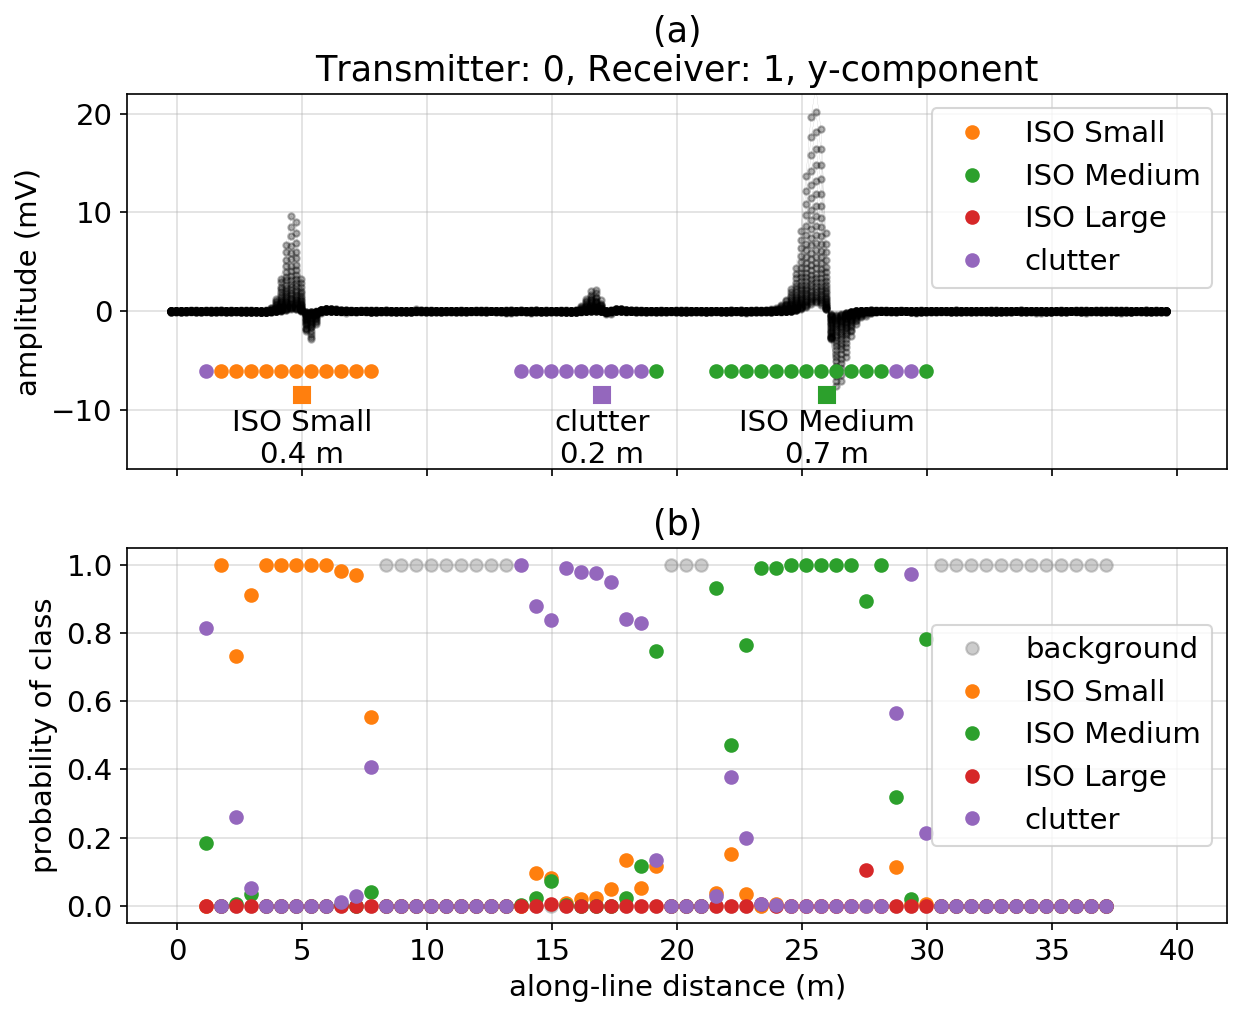

In [57]:
mnum_plot = 12
fig, ax = plt.subplots(2, 1, figsize=(8.5, 7), dpi=150, sharex=True)

background_color = [0.5, 0.5, 0.5]

# ordnance_labels = [
#     Line2D(
#         [0], [0], marker='o', color="w", 
#         markerfacecolor=background_color, markeredgecolor=background_color, 
#         label="background"
#     )
# ]
ordnance_labels = [
    Line2D(
        [0], [0], marker='o', color="w", 
        markerfacecolor=f'C{int(key)}', markeredgecolor=f'C{int(key)}', 
        label=value
    ) for key, value in class_dict.items() if key != 0
]

ax[0].plot(Y_profile[mnum_plot, :], D_profile[mnum_plot, :, :], marker='.', color="k", alpha=0.3, lw=0.1)
ax[0].grid("both", alpha=0.4)

for i in range(net_data_profile.shape[0]):
    y_plot = np.mean(net_y_profile[i, mnum_plot, :])
    if labels_profile[i] == 0:
        color = background_color
    else: 
        ax[0].plot(y_plot, -6, f'C{labels_profile[i]}', marker='o')

txnumplot = sensor_table[mnum_plot, 0]
rxnumplot = sensor_table[mnum_plot, 3]
rxcompplot = sensor_table[mnum_plot, 2]
ax[0].set_title(f"(a)\nTransmitter: {txnumplot}, Receiver: {rxnumplot}, y-component")

ax[0].set_ylabel("amplitude (mV)")

for i in range(len(depths_profile)):
    label = params_profile["label"][i]
    ax[0].plot(params_profile["y"][i], -8.5, f"sC{label}", ms=8)
    ax[0].text(params_profile["y"][i], -16, class_dict[label] + f"\n{depths_profile[i]:1.1f} m", ha="center", va="bottom")

ax[0].legend(handles=ordnance_labels)

# ax.set_xlim([12.5, 17.5])
ax[0].set_ylim([-16, 22])

# ax[0].set_xlabel("along-line distance (m)")
ax[1].set_xlabel("along-line distance (m)")

for i in range(n_class):
    if i == 0:
        ax[1].plot(
            np.mean(net_y_profile[:, mnum_plot, :], 1), probs_profile[:, i], color=background_color,
            marker='o', ms=6, label="background", alpha=0.4, lw=0
        )
    else:
        ax[1].plot(
            np.mean(net_y_profile[:, mnum_plot, :], 1), probs_profile[:, i], f"C{i}",
            marker='o', ms=6, label=class_dict[i], lw=0
        )
ax[1].legend()
ax[1].set_ylabel("probability of class")
ax[1].grid(which="both", alpha=0.4)
ax[1].set_title("(b)")

plt.tight_layout()

for a in ax:
    a.set_xlim([-2, 42])
#     a.set_xlim([25, 31])

if save_figures:
    fig.savefig("figures/profile-line", bbox_inches="tight")

## synthetic test site

In [58]:
synthetic_subset = pd.read_hdf(os.path.sep.join([data_directory, "synthetic_subset.h5"]), "df")
synthetic_data_npz = np.load(os.path.sep.join([data_directory, "synthetic_test_plot.npz"]))

synthetic_data = synthetic_data_npz["synthetic_data"]
synthetic_data_noisy = synthetic_data_npz["synthetic_data_noisy"]
pos_synthetic = synthetic_data_npz["pos_synthetic"]
mnum_synthetic = synthetic_data_npz["mnum_synthetic"]
lines_synthetic = synthetic_data_npz["lines_synthetic"]
theta = synthetic_data_npz["theta"]


In [59]:
window_width = int(ymax/y_spacing)
w_step = 2

In [60]:
def classify_data(local_pos, mn, data, lines):
    classified_X = []
    classified_Y = []
    classified_probs = []
    classified_classes = []

    for line_id in np.unique(lines_synthetic): 
        line_inds = lines == line_id

        x_locs = []
        y_locs = []
        data_list = []
        line_data = data[:, line_inds]
        mn_line = mn[line_inds]
        line_x = local_pos[line_inds, 0]
        line_y = local_pos[line_inds, 1]

        min_mn_num = np.inf
        for mnind in range(mn.max() + 1):    
            mninds = mn_line == mnind
            if mninds.sum() < min_mn_num:
                min_mn_num = mninds.sum()
            x_locs.append(line_x[mninds])
            y_locs.append(line_y[mninds])
            data_list.append(line_data[:, mninds].T)

        X_locs = np.vstack([x[:min_mn_num] for x in x_locs])
        Y_locs = np.vstack([y[:min_mn_num] for y in y_locs])
        S_data = np.stack([d[:min_mn_num, :] for d in data_list], axis=0)

        n_windows = (X_locs.shape[1]-window_width)//w_step + 1
        print(line_id, window_width, w_step, n_windows, X_locs.shape)

        n = S_data.shape
        net_data = np.zeros((n_windows, n[0], window_width, n[2]))
        net_y = np.zeros((n_windows, n[0], window_width))
        net_x = np.zeros((n_windows, n[0], window_width))

        for i in range(n_windows):
            inds = slice(i*w_step,i*w_step+window_width)
            net_x[i, :, :] = X_locs[:, inds]
            net_y[i, :, :] = Y_locs[:, inds]
            net_data[i, :, :, :] = S_data[:, inds, :]

        if use_scaled or use_normalized:
            net_data = net_data * time_scaling

        if use_normalized:
            net_data = normalize_data(net_data)

        net_data_torch = torch.from_numpy(np.float32(net_data))

        with torch.no_grad():
            out_field = net(net_data_torch, K, batch_norm, bias)
            classes_field, probs_field = classify(out_field, W, b)

        classified_X.append(net_x)
        classified_Y.append(net_y)
        classified_probs.append(probs_field.numpy())
        classified_classes.append(classes_field.numpy())
    return {
        "x": classified_X,
        "y": classified_Y,
        "probs": np.vstack(classified_probs),
        "classes": np.hstack(classified_classes)
    }

In [61]:
classify_synthetic = classify_data(pos_synthetic, mnum_synthetic, synthetic_data_noisy.T, lines_synthetic)

1001.0 15 2 166 (165, 345)
1002.0 15 2 175 (165, 363)
1003.0 15 2 173 (165, 360)
1004.0 15 2 176 (165, 366)
1005.0 15 2 178 (165, 369)
1006.0 15 2 174 (165, 361)
1007.0 15 2 4 (165, 21)
1008.0 15 2 180 (165, 374)
1009.0 15 2 8 (165, 29)
1010.0 15 2 182 (165, 378)
1011.0 15 2 196 (165, 405)
1012.0 15 2 188 (165, 390)
1013.0 15 2 196 (165, 405)
1014.0 15 2 190 (165, 393)


In [62]:
synthetic_X_means = np.hstack([cx.mean(1).mean(1) for cx in classify_synthetic["x"]])
synthetic_Y_means = np.hstack([cy.mean(1).mean(1) for cy in classify_synthetic["y"]])

synthetic_eastings  = np.cos(theta) * synthetic_X_means - np.sin(theta) * synthetic_Y_means  
synthetic_northings = np.sin(theta) * synthetic_X_means + np.cos(theta) * synthetic_Y_means 

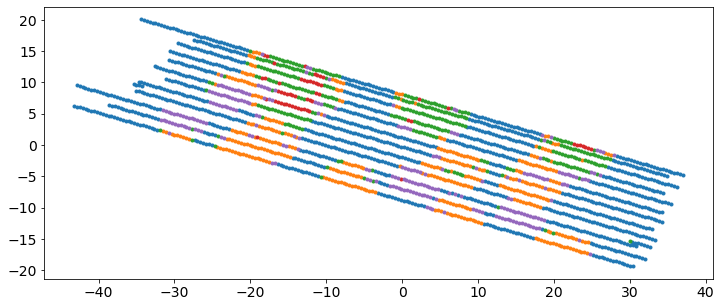

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
for key, val in class_dict.items():
    inds = classify_synthetic["classes"] == key
    ax.plot(
        synthetic_eastings[inds], synthetic_northings[inds], f"C{key}o", ms=3, label=val
    )

//miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


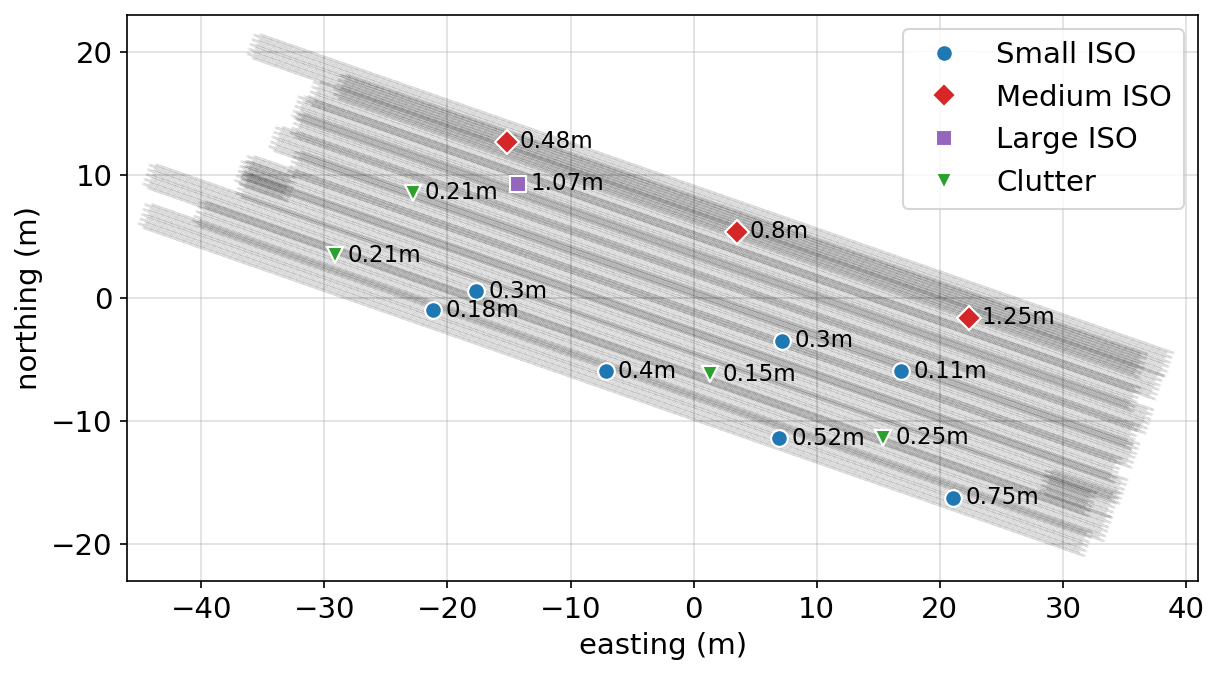

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)

ax.grid(which="both", alpha=0.4)

xplt = pos_synthetic[:, 0]
yplt = pos_synthetic[:, 1]

eplot = np.cos(theta) * xplt - np.sin(theta) * yplt 
nplot = np.sin(theta) * xplt + np.cos(theta) * yplt 

# for i, li in enumerate(np.unique(lines_synthetic)):
    
ax.plot(eplot, nplot, "k.", ms=0.01, alpha=0.95)

for i, item in enumerate(synthetic_subset["item"]):
    x = synthetic_subset["easting"][i]
    y = synthetic_subset["northing"][i]
    if item == "Small ISO":
        ax.plot(x, y, 'C0o', ms=8, mec="w")
    elif item == "Medium ISO": 
        ax.plot(x, y, 'C3D', ms=8, mec="w")
    elif item == "Large ISO":
        ax.plot(x, y, 'C4s', ms=8, mec="w")
    elif item == "20mm":
        ax.plot(x, y, 'C2v', ms=8, mec="w")
    
    ax.text(x+1, y-0.5, f"\n{synthetic_subset['depth'][i]}m", ha="left", fontsize=11)

    
        
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], c="w", marker='o', ms=8, mec="w", mfc='C0'),
                Line2D([0], [0], c="w", marker="D", ms=8, mec="w", mfc='C3'),
                Line2D([0], [0], c="w", marker='s', ms=8, mec="w", mfc='C4'),
                Line2D([0], [0], c="w", marker='v', ms=8, mec="w", mfc='C2'),
               ]

ax.legend(custom_lines, ["Small ISO", "Medium ISO", "Large ISO", "Clutter"]) #"Medium ISO", "Large ISO", "20mm"])
ax.set_xlabel("easting (m)")
ax.set_ylabel("northing (m)")
cb.set_label("probability Small ISO")
ax.set_xlim(np.r_[-46, 41])
ax.set_ylim(np.r_[-23, 23])
# ax.set_ylim(6.1007e6 + np.r_[35, 76])
ax.set_aspect(1)

if save_figures: 
    fig.savefig("figures/synthetic-test-plot", bbox_inches="tight")

//miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


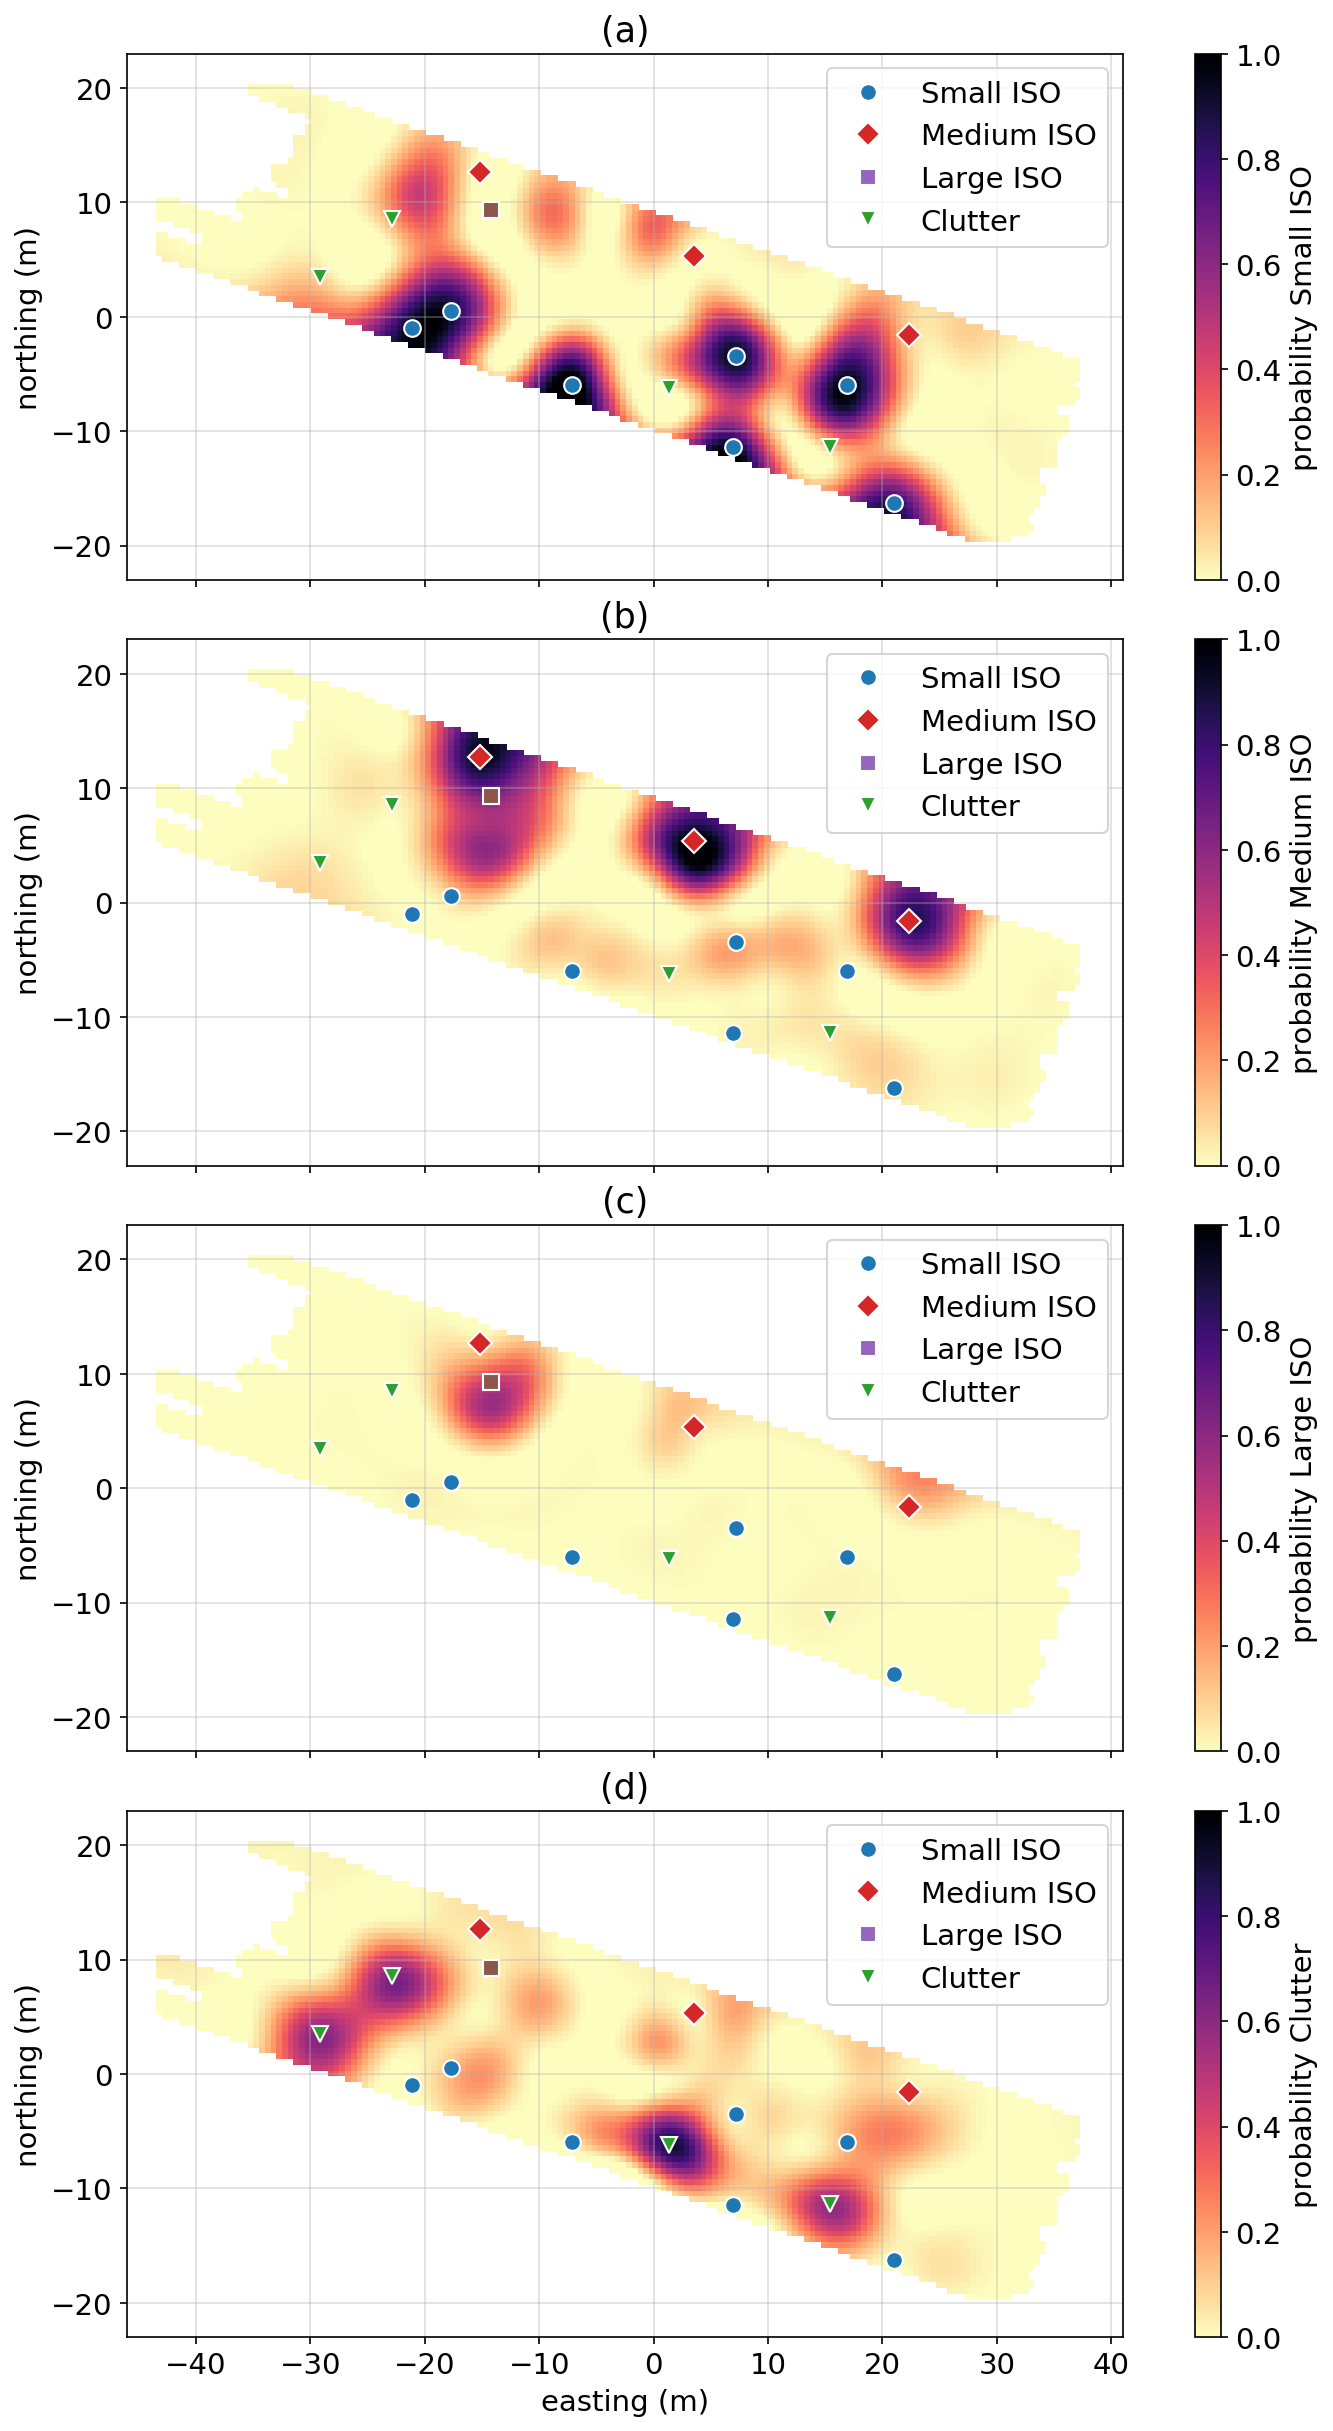

In [65]:
coordinates = (synthetic_eastings, synthetic_northings)
spacing = 0.5

fig, ax = plt.subplots(4, 1, figsize=(10, 16), dpi=150, sharex=True)

chain = vd.Chain([
    ("mean", vd.BlockMean(spacing=spacing)),
    ("spline", vd.Spline(damping=1e-3)),
])

region = vd.get_region(coordinates)

for i, title, a in zip([1, 2, 3, 4], ["Small ISO", "Medium ISO", "Large ISO", "Clutter"], ax):
    chain.fit(coordinates, classify_synthetic["probs"][:, i])  

    grid = chain.grid(
        region=region,
        spacing=spacing, 
        dims=["easting (m)", "northing (m)"],
        data_names=["prob_small_iso"]
    )

    cm = plt.get_cmap('magma_r')
    c_norm = Normalize(vmin=0., vmax=1.)
    scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
    scalar_map.set_array([])

    mask = vd.distance_mask(
        coordinates,
        maxdist=1,
        grid=grid
    )

    pc = mask.prob_small_iso.plot.pcolormesh(
        ax=a, vmin=0, vmax=1, cmap=cm, add_colorbar=False
    )
    cb = plt.colorbar(pc, ax=a)
    
                    
    a.set_xlim(np.r_[-46, 41])
    a.set_ylim(np.r_[-23, 23])
    a.set_aspect(1)
    a.grid(which="both", alpha=0.4)

    for j, item in enumerate(synthetic_subset["item"]):
        if item == "Small ISO":
            a.plot(synthetic_subset["easting"][j], synthetic_subset["northing"][j], 'C0o', ms=8, mec="w")
        elif item == "Medium ISO": 
            a.plot(synthetic_subset["easting"][j], synthetic_subset["northing"][j], 'C3D', ms=8, mec="w")
        elif item == "Large ISO":
            a.plot(synthetic_subset["easting"][j], synthetic_subset["northing"][j], 'C5s', ms=8, mec="w")
        elif item == "20mm":
            a.plot(synthetic_subset["easting"][j], synthetic_subset["northing"][j], 'C2v', ms=8, mec="w")

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], c="w", marker='o', ms=8, mec="w", mfc='C0'),
                    Line2D([0], [0], c="w", marker="D", ms=8, mec="w", mfc='C3'),
                    Line2D([0], [0], c="w", marker='s', ms=8, mec="w", mfc='C4'),
                    Line2D([0], [0], c="w", marker='v', ms=8, mec="w", mfc='C2'),
                   ]

    a.legend(custom_lines, ["Small ISO", "Medium ISO", "Large ISO", "Clutter"]) #"Medium ISO", "Large ISO", "20mm"])
    a.set_ylabel("northing (m)")
    a.set_xlabel("")
    cb.set_label(f"probability {title}")

plt.tight_layout()
    
ax[3].set_xlabel("easting (m)")

for i, a in enumerate(ax):
    a.set_title(f"({ascii_lowercase[i]})")
    a.set_aspect(1)

if save_figures:
    fig.savefig("figures/synthetic-field-probs", bbox_inches="tight")